In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import h2o
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
pd.set_option('display.max_columns', None)
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [2]:
def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print (classifier)
    print ("Accuracy is: %0.3f" % accuracy)
    print ("precision is: %0.3f" % precision)
    print ("recall is: %0.3f" % recall)

# print out confusion matrices
def draw_confusion_matrices(confusion_matricies):
    class_names = ['Not Default','Default']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

In [121]:
df = pd.read_csv('./total_varaibles.csv',index_col=False)

In [122]:
y = df['default']
df.drop(columns='default',inplace=True)
X = df.values
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Use Sklearn - Logistic/KNN/RandomForest

In [5]:
# Logistic Regression
classifier_logistic = LogisticRegression()

# K Nearest Neighbors
classifier_KNN = KNeighborsClassifier()

# Random Forest
classifier_RF = RandomForestClassifier()

### Fit three models first

In [7]:
classifier_logistic.fit(X_train, y_train)
pred_log = classifier_logistic.predict(X_test)

classifier_KNN.fit(X_train, y_train)
pred_knn = classifier_KNN.predict(X_test)

classifier_RF.fit(X_train, y_train)
pred_rf = classifier_RF.predict(X_test)

### Result:

- #### Look at Confusion Matrix

Logistic Regression
Accuracy is: 0.812
precision is: 0.524
recall is: 0.019


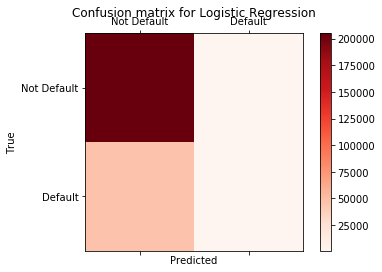

KNN
Accuracy is: 0.785
precision is: 0.300
recall is: 0.107


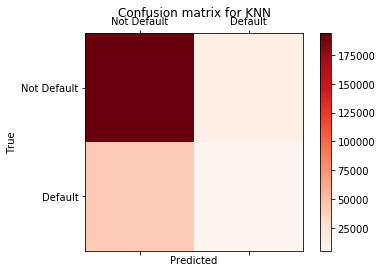

Random Forest
Accuracy is: 0.805
precision is: 0.403
recall is: 0.075


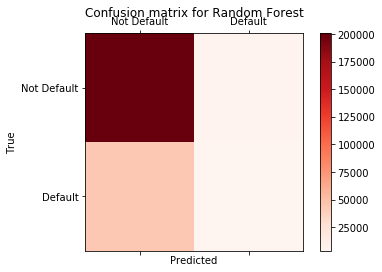

In [30]:
%matplotlib inline

# Confusion matrix, accuracy, precison and recall for random forest and logistic regression
confusion_matrices = [
    ("Logistic Regression", confusion_matrix(y_test,pred_log)),
    ("KNN", confusion_matrix(y_test,pred_knn)),
    ("Random Forest", confusion_matrix(y_test,pred_rf)),
]
#confusion_matrices
draw_confusion_matrices(confusion_matrices)

- Potentail problem: even though accuracy is not bad, the precision and recall are pretty low, especially recall, which means many default cases are not catched because of thredhold setting of 0.5 as cut-point. Let's consider a higher cut-point to improve recall. 

- #### Look at F1-Score

In [36]:
# Take a look at F1-Score
from sklearn.metrics import f1_score
f1score = [
    ("Logistic Regression", f1_score(y_test,pred_log)),
    ("KNN", f1_score(y_test,pred_knn)),
    ("Random Forest", f1_score(y_test,pred_rf)),
]
f1score

[('Logistic Regression', 0.035756853396901066),
 ('KNN', 0.15788743467603938),
 ('Random Forest', 0.1260320372591913)]

- Logistic Regression has lowest F1-Score because of its extremly low recall.

- #### Look at AUC

In [42]:
for model, pred in [('Logistic Regression', pred_log), ('KNN', pred_knn), ('Random Forest',pred_rf)]:
    fpr, tpr, thresholds =roc_curve(y_test,pred)
    roc_auc = auc(fpr, tpr)
    print("Area under the ROC curve of {0:10s} : {1:5.4f}".format(model, roc_auc))

Area under the ROC curve of Logistic Regression : 0.5073
Area under the ROC curve of KNN        : 0.5246
Area under the ROC curve of Random Forest : 0.5245


- Current models are just slightly better than random guessing

## Will standardization/normalization be useful?

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
classifier_logistic.fit(X_train, y_train)
pred_log = classifier_logistic.predict(X_test)

In [8]:
fpr, tpr, thresholds =roc_curve(y_test,pred_log)
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve of {0:10s} : {1:5.4f}".format('Logistic Regression', roc_auc))

Area under the ROC curve of Logistic Regression : 0.5171


In [9]:
classifier_RF.fit(X_train, y_train)
pred_rf = classifier_RF.predict(X_test)

In [10]:
fpr, tpr, thresholds =roc_curve(y_test,pred_rf)
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve of {0:10s} : {1:5.4f}".format('Random Forest', roc_auc))

Area under the ROC curve of Random Forest : 0.5240


- ### It's somewhat useful for only logistic regression model

In [11]:
df.shape

(768532, 70)

## Use Grid-Search to Improve the Random Forest Model

In [12]:
from sklearn.model_selection import GridSearchCV

# helper function for printing out grid search results 
def print_grid_search_metrics(gs):
    print ("Best score: %0.3f" % gs.best_score_)
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [13]:
# Possible hyperparamter options for Random Forest
# Choose the number of trees
parameters = {
    'n_estimators' : [30,40,50]
}
Grid_RF = GridSearchCV(RandomForestClassifier(),parameters, cv=5)
Grid_RF.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [30, 40, 50]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [14]:
# best number of tress
print_grid_search_metrics(Grid_RF)

Best score: 0.813
Best parameters set:
	n_estimators: 50


In [15]:
# best random forest
best_RF_model = Grid_RF.best_estimator_

In [16]:
# Use predict_proba to get the probability results of Random Forest
y_pred_rf = best_RF_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

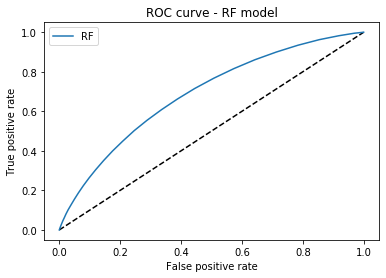

In [17]:
# ROC curve of Random Forest result
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - RF model')
plt.legend(loc='best')
plt.show()

In [18]:
fpr, tpr, thresholds =roc_curve(y_test,y_pred_rf)
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve of {0:10s} : {1:5.4f}".format('Random Forest', roc_auc))

Area under the ROC curve of Random Forest : 0.6881


- #### It's improved a lot from 0.52

### H2o Random Forest

Good thing: No need to self-encode

In [3]:
numeric_lst = ['default','dti','loan_amnt',
 'funded_amnt',
 'int_rate',
 'installment',
 'fico_range_low',
 'annual_inc',
 'delinq_2yrs',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'pub_rec_bankruptcies']

cate_lst = ['addr_state','initial_list_status','verification_status','emp_length','grade']

In [4]:
df = pd.read_csv('./MORTGAG07-18_TOTAL_WITH_DEFAULT_SELECTED.csv')
df = df.reindex(sorted(df.columns), axis=1)

In [5]:
new_df = df[numeric_lst+cate_lst]

In [6]:
import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

# Initialize H2O cluster
h2o.init()
h2o.remove_all()

# Transform to H2O Frame, and make sure the target variable is categorical
h2o_df = H2OFrame(new_df)

for i in cate_lst:
    
    h2o_df[i] = h2o_df[i].asfactor()

h2o_df.summary()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "11.0.4" 2019-07-16 LTS; Java(TM) SE Runtime Environment 18.9 (build 11.0.4+10-LTS); Java HotSpot(TM) 64-Bit Server VM 18.9 (build 11.0.4+10-LTS, mixed mode)
  Starting server from /Users/guomeng/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/16/mgyj8wx57x3bllpc65q6xytm0000gn/T/tmplnmdq_8r
  JVM stdout: /var/folders/16/mgyj8wx57x3bllpc65q6xytm0000gn/T/tmplnmdq_8r/h2o_guomeng_started_from_python.out
  JVM stderr: /var/folders/16/mgyj8wx57x3bllpc65q6xytm0000gn/T/tmplnmdq_8r/h2o_guomeng_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/Chicago
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,12 days
H2O cluster name:,H2O_from_python_guomeng_hc13hs
H2O cluster total nodes:,1
H2O cluster free memory:,2 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%


,default,dti,loan_amnt,funded_amnt,int_rate,installment,fico_range_low,annual_inc,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,pub_rec_bankruptcies,addr_state,initial_list_status,verification_status,emp_length,grade
type,int,real,int,int,enum,real,int,real,int,int,int,int,int,enum,enum,enum,enum,enum
mins,0.0,-1.0,500.0,500.0,,16.08,615.0,0.0,0.0,0.0,0.0,0.0,0.0,,,,,
mean,0.18692260049028536,18.573648067384415,16099.530858832162,16090.25469986936,,478.72002303092074,699.529232354671,86548.6541694426,0.3575186233369113,0.6691853474972811,12.303144334927282,0.21159623954978715,0.1312682195815177,,,,,
maxs,1.0,999.0,40000.0,40000.0,,1719.83,845.0,9550000.0,42.0,33.0,90.0,86.0,9.0,,,,,
sigma,0.3898496372621613,12.920053430638157,9178.821296513857,9175.895671939823,,273.246019632909,33.32343231945292,75885.76402330166,0.9155828368014342,0.9673253186044233,5.5062223757409425,0.5920394073043602,0.36763455277648677,,,,,
zeros,624876,442,0,0,,0,0,391,603086,437908,1,638954,673338,,,,,
missing,0,402,0,0,0,0,0,0,7,8,7,7,471,0,0,0,0,0
0,1.0,14.92,10400.0,10400.0,6.99%,321.08,710.0,58000.0,0.0,2.0,17.0,0.0,0.0,CA,w,Not Verified,8 years,A
1,0.0,23.63,17000.0,17000.0,13.66%,578.22,675.0,75000.0,0.0,0.0,7.0,0.0,0.0,NY,f,Verified,10+ years,C
2,0.0,13.77,2500.0,2500.0,11.99%,83.03,685.0,89000.0,0.0,1.0,9.0,0.0,0.0,MN,f,Source Verified,< 1 year,B


In [7]:
strat_split = h2o_df['default'].stratified_split(test_frac=0.33, seed=42)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

feature = numeric_lst+cate_lst
target = 'default'

In [8]:
# Build random forest model
model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, max_depth=20, 
                                 mtries=-1, seed=42, score_each_iteration=True)
model.train(x=feature, y=target, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


#### H2o Feature importance

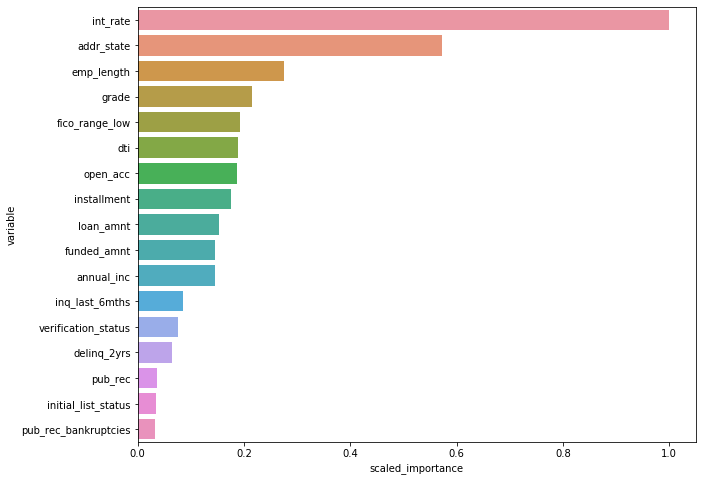

In [9]:
# Feature importance
importance = model.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.show()

- #### Most important variable is interest rate, which makes sense since if the interest rate is high, then the individual is with higher risk.

In [11]:
# Make predictions
train_true = train.as_data_frame()['default'].values
test_true = test.as_data_frame()['default'].values
train_pred = model.predict(train).as_data_frame()['predict'].values
test_pred = model.predict(test).as_data_frame()['predict'].values

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [12]:
# Classification report
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.82      0.99      0.90    206209
           1       0.50      0.05      0.08     47406

   micro avg       0.81      0.81      0.81    253615
   macro avg       0.66      0.52      0.49    253615
weighted avg       0.76      0.81      0.74    253615



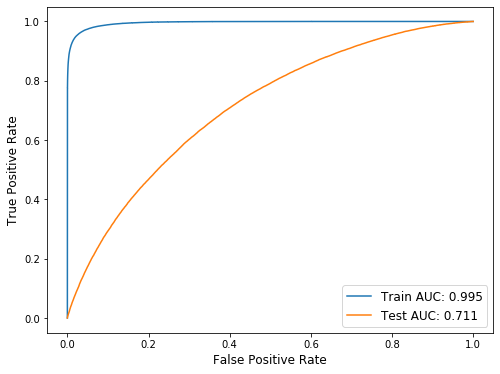

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

- #### Improved AUC from 0.68 to 0.71 using H2o instead of sklearn

## Use Deep Learning

In [115]:
X, y = make_classification(n_samples=80000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [125]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [136]:
model = Sequential()
model.add(Dense(125, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(50))
model.add(Dense(20))
model.add(Dense(20))
model.add(Dense(y_train.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')
model.fit(X_train,y_train,validation_data=(X_test,y_test),verbose=2,epochs=10)

Train on 514916 samples, validate on 253616 samples
Epoch 1/10
514916/514916 - 18s - loss: 13.1179 - accuracy: 0.1861 - val_loss: 13.0796 - val_accuracy: 0.1885
Epoch 2/10
514916/514916 - 17s - loss: 13.1179 - accuracy: 0.1861 - val_loss: 13.0796 - val_accuracy: 0.1885
Epoch 3/10
514916/514916 - 17s - loss: 13.1179 - accuracy: 0.1861 - val_loss: 13.0796 - val_accuracy: 0.1885
Epoch 4/10
514916/514916 - 17s - loss: 13.1179 - accuracy: 0.1861 - val_loss: 13.0796 - val_accuracy: 0.1885
Epoch 5/10
514916/514916 - 17s - loss: 13.1179 - accuracy: 0.1861 - val_loss: 13.0796 - val_accuracy: 0.1885
Epoch 6/10
514916/514916 - 17s - loss: 13.1179 - accuracy: 0.1861 - val_loss: 13.0796 - val_accuracy: 0.1885
Epoch 7/10
514916/514916 - 17s - loss: 13.1179 - accuracy: 0.1861 - val_loss: 13.0796 - val_accuracy: 0.1885
Epoch 8/10
514916/514916 - 17s - loss: 13.1179 - accuracy: 0.1861 - val_loss: 13.0796 - val_accuracy: 0.1885
Epoch 9/10
514916/514916 - 17s - loss: 13.1179 - accuracy: 0.1861 - val_loss

In [117]:
y_pred_keras = model.predict(X_test).ravel()
y_pred_keras_train = model.predict(X_train).ravel()
fpr_keras_test, tpr_keras_test, thresholds_keras_test = roc_curve(y_test, y_pred_keras)
auc_keras_test = np.round(auc(fpr_keras_test, tpr_keras_test),3)
fpr_keras_train, tpr_keras_train, thresholds_keras_train = roc_curve(y_train, y_pred_keras_train)
auc_keras_train = np.round(auc(fpr_keras_train, tpr_keras_train),3)

In [137]:
model.predict(X_test)

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [138]:
y_test

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [140]:
# fig, ax = plt.subplots(figsize=(8, 6))
# ax.plot(fpr_keras_train, tpr_keras_train, label='Train AUC: ' + str(auc_keras_train))
# ax.plot(fpr_keras_test, tpr_keras_test, label='Test AUC: ' + str(auc_keras_test))
# ax.set_xlabel('False Positive Rate', fontsize=12)
# ax.set_ylabel('True Positive Rate', fontsize=12)
# ax.legend(fontsize=12)
# plt.show()